In [11]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as rx
import rioxarray as rix

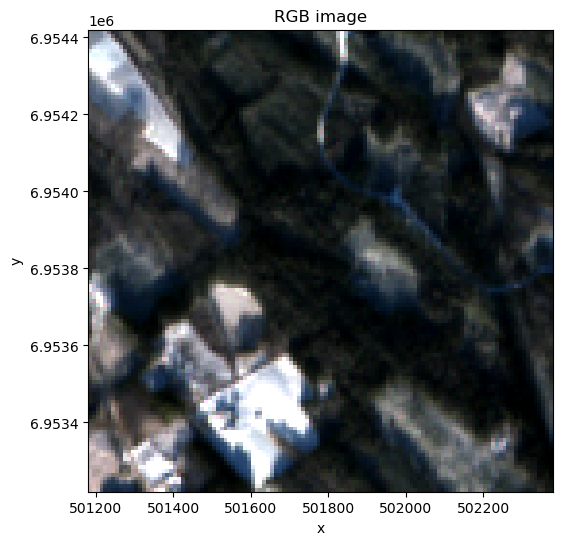

0.8122470931107811


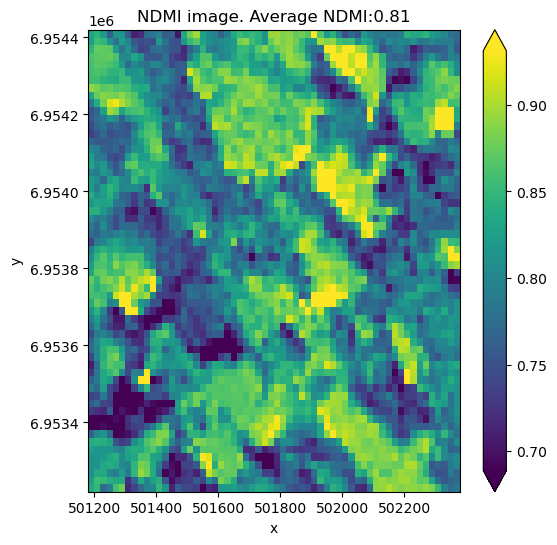

In [67]:
# Read GeoTIFF file
def norm_diff(x,y):
    return (x-y)/(x+y)

child = "S2A_MSIL2A_20171101T094131_1_38"

def plot_folder(folder,rgb=True):
    parent = "data/"
    if rgb:
        plt.figure(figsize=(6, 6))
        blue = rix.open_rasterio(parent+f"{folder}/{folder}_B02.tif")
        green = rix.open_rasterio(parent+f"{folder}/{folder}_B03.tif")
        red = rix.open_rasterio(parent+f"{folder}/{folder}_B04.tif")

        rgb_img = rx.concat([red, green, blue], dim='band')
        # rgb_img = (red+green+blue).squeeze()
        rgb_img.plot.imshow(robust=True)
        plt.title("RGB image")
        plt.show()

    elif not rgb:
        plt.figure(figsize=(6, 6))
        nir = rix.open_rasterio(parent+f"{folder}/{folder}_B8A.tif")
        swir = rix.open_rasterio(parent+f"{folder}/{folder}_B11.tif")
        avg_ndmi = np.mean(norm_diff(nir.values,swir.values).squeeze())
        ndmi_img = norm_diff(nir,swir).squeeze()
        print(avg_ndmi)
        # plt.imshow(ndmi)
        # plt.colorbar(label='Pixel Values')
        # plt.title('GeoTIFF Image')
        # plt.show()
        ndmi_img.plot.imshow(robust=True)
        plt.title(f"NDMI image. Average NDMI:{avg_ndmi:.2f}")
        plt.show()

plot_folder(child,rgb=True)
plot_folder(child,rgb=False)
